# Some PDAL testing and fun in python

This notebook uses PDAL as a python library. Nothing really complicated happens here, we're demonstrating how things can be done.

### Import all the things

In [235]:
import pdal

import numpy as np

import json
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


### Set matplotlib to plot inline

In [236]:
%matplotlib inline

### Define a function to read a LAS/LAZ file and return a Pandas dataframe 

In [237]:
def pdal2df(pipelineJson,workingfile):
    """
    Feed me a LAS/LAZ file and a JSON pipeline, get back a Pandas dataframe with points in it.
    """
    pipeline = pdal.Pipeline(json.dumps(pipelineJson))
    pipeline.validate() # check if our JSON and options were good
    pipeline.loglevel = 8 #really noisy
    count = pipeline.execute()
    arrays = pipeline.arrays

    arr = pipeline.arrays[0]
    description = arr.dtype.descr
    cols = [col for col, __ in description]
    df = pd.DataFrame({col: arr[col] for col in cols})
    
    return df

### Define another function to make plots... but keep it simple!

In [299]:
def plotthethings(dataframe, Zdim, npoints):
    """
    Input is a Pandas dataframe with PDAL dimensions as columns, output is a two panel plot with a 3D plot in the top panel and a 2D plot below

    """
    fig = plt.figure(figsize=(20,20))

    ax = fig.add_subplot(211, projection='3d')

    ax.scatter(dataframe.X[0:npoints].where(dataframe.Classification[0:npoints] != 2),
           dataframe.Y[0:npoints].where(dataframe.Classification[0:npoints] != 2),
           Zdim[0:npoints].where(dataframe.Classification[0:npoints] != 2),
           c=dataframe.Intensity[0:npoints].where(dataframe.Classification[0:npoints] != 2), alpha=0.4, cmap='Greens')
    
    ax.scatter(dataframe.X[0:npoints].where(dataframe.Classification[0:npoints] == 2),
           dataframe.Y[0:npoints].where(dataframe.Classification[0:npoints] == 2),
           Zdim[0:npoints].where(dataframe.Classification[0:npoints] == 2),
           c=Zdim[0:npoints].where(dataframe.Classification[0:npoints] == 2), cmap='gist_gray')
    
    ax.scatter(dataframe.X[0:npoints].where(dataframe.Classification[0:npoints] == 7),
           dataframe.Y[0:npoints].where(dataframe.Classification[0:npoints] == 7),
           Zdim[0:npoints].where(dataframe.Classification[0:npoints] == 7),
           c='red')

    ax.view_init(30,70)

    ax.legend(['not ground', 'ground', 'noise'])

    ax2 = fig.add_subplot(212)

    ax2.scatter(dataframe.X[0:npoints].where(dataframe.Classification[0:npoints] != 2),
            dataframe.Y[0:npoints].where(dataframe.Classification[0:npoints] != 2),
            c=Zdim[0:npoints].where(dataframe.Classification[0:npoints] != 2), cmap='Greens')
    ax2.scatter(dataframe.X[0:npoints].where(dataframe.Classification[0:npoints] == 2),
            dataframe.Y[0:npoints].where(dataframe.Classification[0:npoints] == 2),
            c='gray')
    ax2.scatter(dataframe.X[0:npoints].where(dataframe.Classification[0:npoints] == 7),
            dataframe.Y[0:npoints].where(dataframe.Classification[0:npoints] == 7),
            c='red')

    ax2.legend(['not ground', 'ground', 'noise'])

    ax.axis('tight')
    
    plt.show()
    

### Define a working file and a pipeline

In [239]:
workingfile = "../../sample-data/T_316000_235500.laz"

In [240]:
pipelineJson = {
  "pipeline": [ workingfile,
    {
        "type":"filters.mortonorder",
        "reverse":"true"
    },
  ]
}

<div class="alert alert-info">
<strong>Do this in docker like:</strong>

<pre>
docker run -it -v /path/to/workingdir:/opt/data pdal/ubuntu:1.8 \
                  pdal translate /opt/data/T_316000_235500.laz \
                  --filters.mortonorder.reverse=True \
                  --writers.las.filename=/opt/data/reversemorton.laz
</pre>

...and view the result using Cloudcompare (or other software)
</div>

### Create a dataframe and inspect it

You should see all the PDAL dimensions exposed as columns in the dataframe

In [241]:
%%time
df = pdal2df(pipelineJson, workingfile)

CPU times: user 9.32 s, sys: 579 ms, total: 9.9 s
Wall time: 9.49 s


In [242]:
df.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime
0,316030.431,235500.003,15.866,26,4,4,1,0,2,29.0,0,21,394503.605232
1,316030.357,235500.188,15.848,47,3,3,1,0,2,30.0,0,21,394503.605235
2,316030.192,235500.044,15.850,39,2,2,1,1,2,30.0,0,21,394503.614611
3,316301.870,235500.099,14.999,224,1,1,1,0,2,-5.0,0,21,394493.027207
4,316301.947,235500.098,14.990,295,1,1,1,0,2,11.0,0,22,394798.492154


### Visualise some data

We're only plotting a few thousand points in the dataset - but it covers most of the plot region. That's the wonder of the reverse morton order filter!

The morton order filter usually puts things close together in (2D) space close together in the array - so plotting the first 10 000 points would result in a compact block (try it!). The reverse filter distributes points across space such that the density fills in as you move down the array.

(316007.47585, 316507.23115, 235480.99385, 235899.12915)

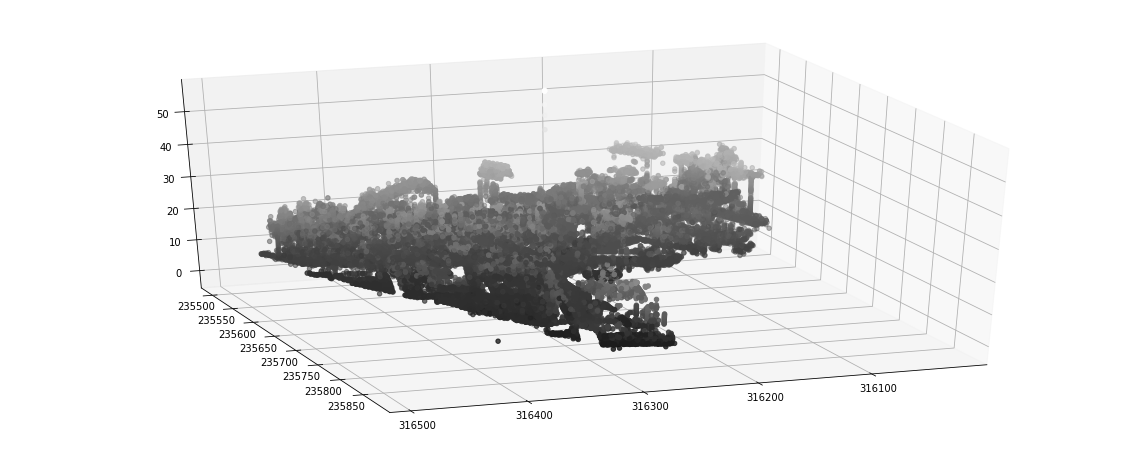

In [307]:
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')

ax.scatter(df.X[0:50000], df.Y[0:50000], df.Z[0:50000], c=df.Z[0:50000], cmap='Greys_r')
ax.view_init(30, 70)

ax.axis('tight')

### Making a more useful plot

Plotting heights is kind of cool, but we want to know stuff about the data. Let's pick on 'is the ground classification useful'?

In ASPRS terms, ground is always 'class 2', and we can see from inspecting the data frame that some points are classified as ground. So let's look.

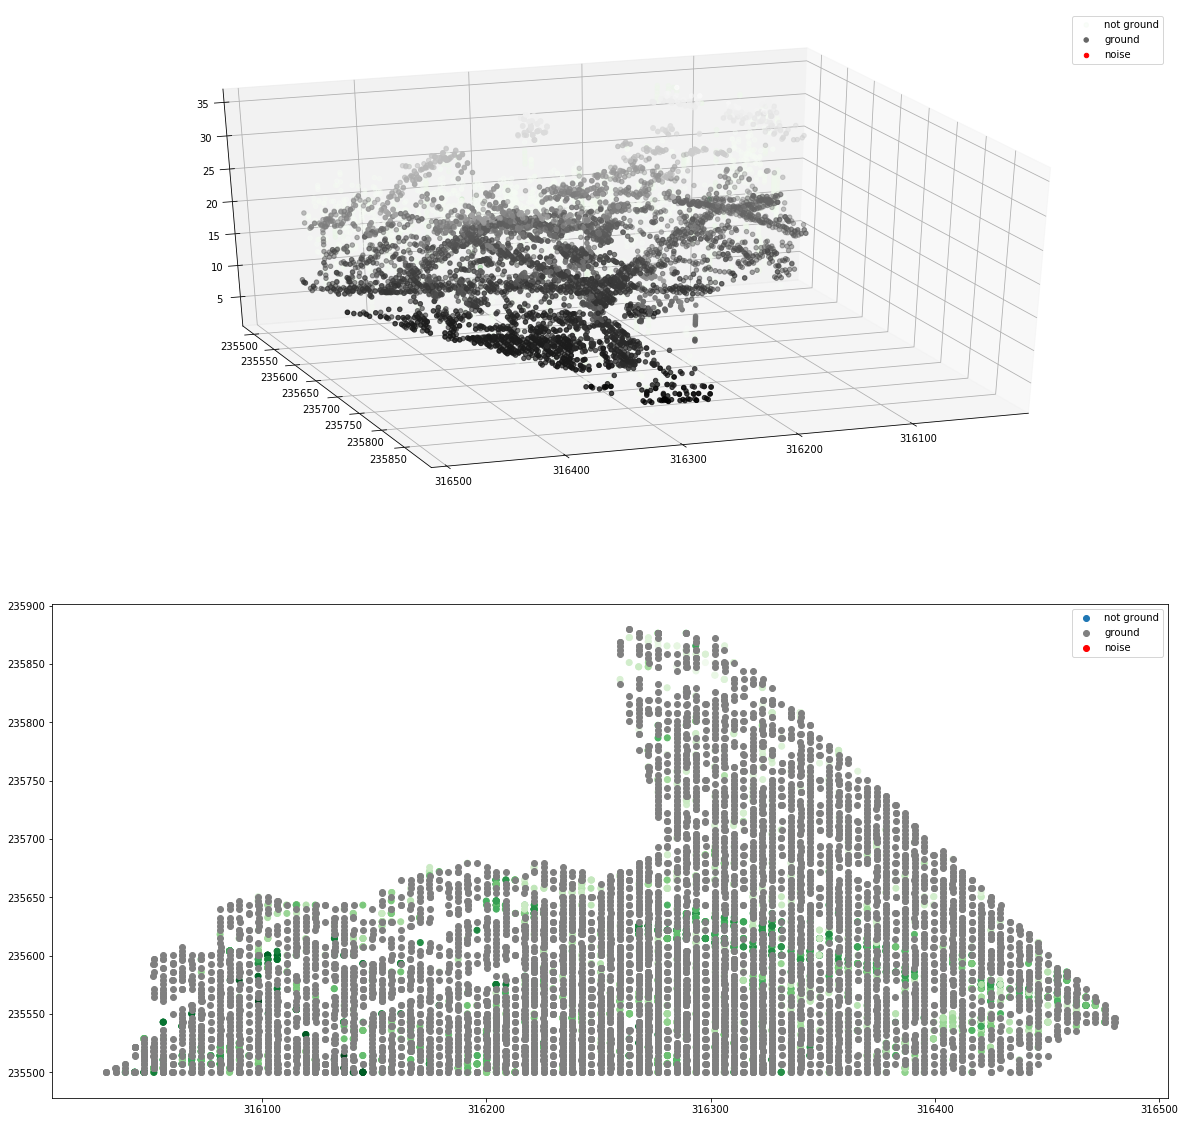

In [309]:
plotthethings(df, df.Z, 10000)

### Something's not right here...

That's a lot of ground! Perhaps we can use our new friend PDAL to do better.

Gathering what we learned about in pipelines, we'll label all points as 'unclassified'; apply a local minimum filter then a progressive morphological filter to clean some noise, then label some points as 'ground'.

We're also adding a morton order filter - in reverse. That'll be explained soon!

In [260]:
pipelineJson2 = {
  "pipeline": [ workingfile,
    {
        "type":"filters.assign",
        "assignment":"Classification[:]=0"
    },
    {
        "type":"filters.elm"
    },
    {
        "type":"filters.pmf",
        "ignore":"Classification[7:7]"
    },
    {   "type":"filters.mortonorder",
        "reverse": True
    }
  ]
}

In [261]:
%%time

df2 = pdal2df(pipelineJson2, workingfile)

CPU times: user 13.1 s, sys: 674 ms, total: 13.8 s
Wall time: 13.3 s


### Visual inspection time

All the cool kids make plotting functions. I might get that done by workshop time, but for now - we're plotting ground and not ground, again..

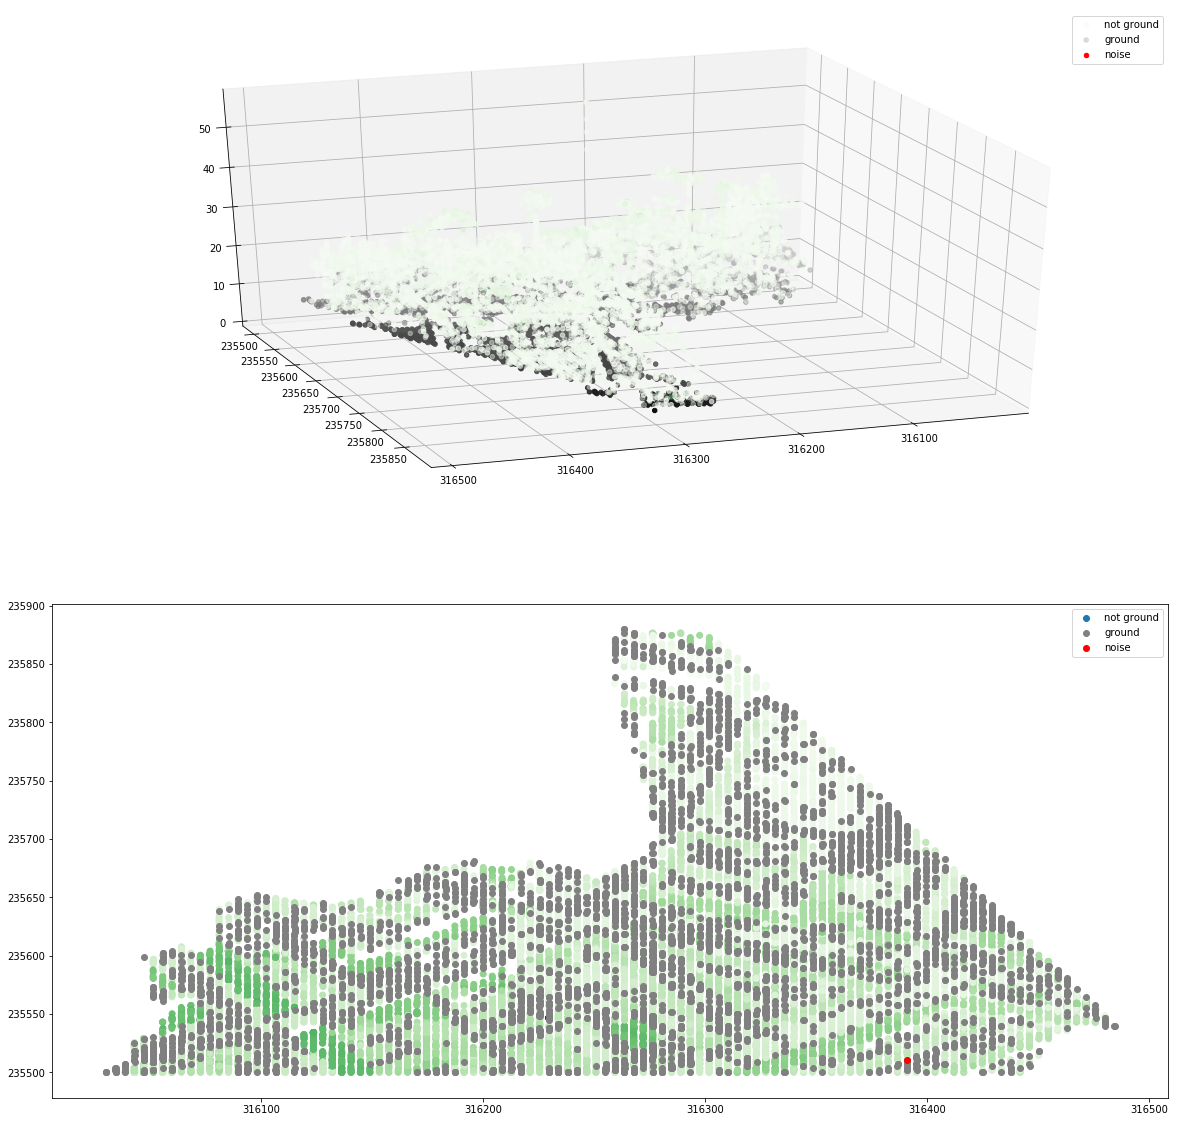

In [308]:
plotthethings(df2, df2.Z, 20000)

### That's better!

We're happier with ground classes now. We can see some buildings, and features that might be roads..

<div class="alert alert-info">
<strong>Do this in docker like:</strong><br />

Save the pipeline JSON given above to:<pre>/path/to/workingdir/classifyground.json</pre>

Then run:

<pre>
docker run -it -v /path/to/workingdir:/opt/data pdal/ubuntu:1.8 \
                  pdal translate -i /opt/data/T_316000_235500.laz \
                  -o /opt/data/reversemorton-ground.laz \
                  --json /opt/data/classifyground.json  \
</pre>               

...and view the result using Cloudcompare (or other software)
</div>

### Next step - height above ground

Now we have ground, we can get some relative heights of things - using `filters.hag`, we'll create an extra dimension `HeightAboveGround` in our dataset, giving... heights above ground!

In [263]:
pipelineJson3 = {
  "pipeline": [ workingfile,
    {
        "type":"filters.assign",
        "assignment":"Classification[:]=0"
    },
    {
        "type":"filters.elm",
        "cell":20.0,
        "class":7
    },
    {
        "type":"filters.pmf",
        "ignore":"Classification[7:7]"
    },
    {
        "type":"filters.outlier"
    },
    {
        "type":"filters.hag"
    },
    {   "type":"filters.mortonorder",
        "reverse": True
    }
  ]
}

In [264]:
%%time

df3 = pdal2df(pipelineJson3, workingfile)

CPU times: user 59.5 s, sys: 1.09 s, total: 1min
Wall time: 59.9 s


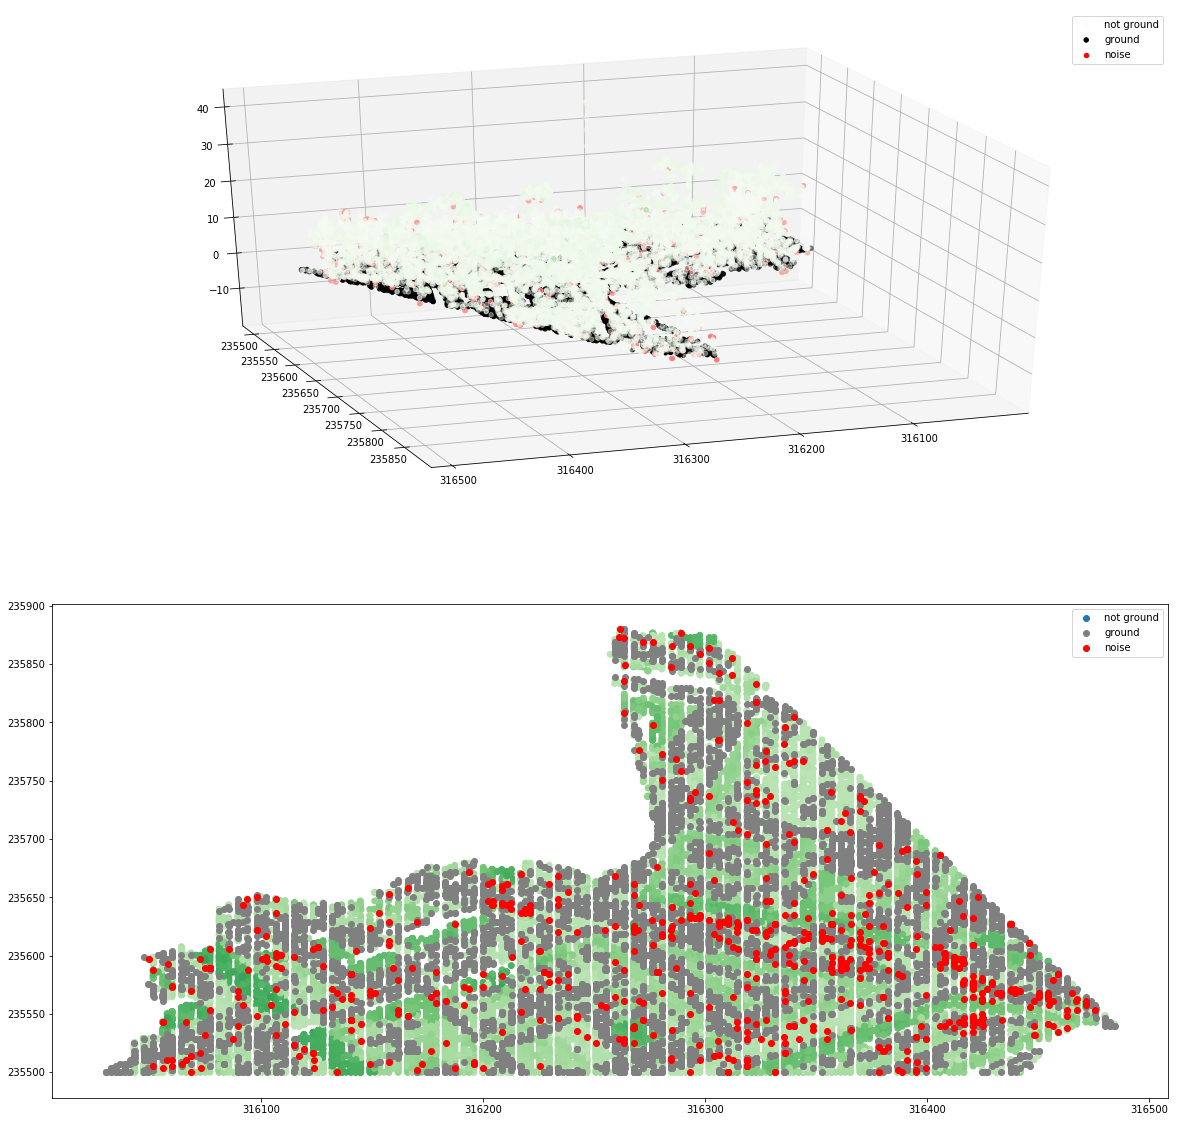

In [310]:
plotthethings(df3, df3.HeightAboveGround, 30000)

In [266]:
print("max height above ground: {} m".format(df3.HeightAboveGround.where(df3.Classification != 7).max()))
print("max height: {} m".format(df.Z.where(df3.Classification != 7).max()))

max height above ground: 44.330000000000005 m
max height: 59.915 m


In [267]:
print("min height above ground: {} m".format(df3.HeightAboveGround.where(df3.Classification != 7).min()))
print("min height: {} m".format(df3.Z.where(df3.Classification != 7).min()))

min height above ground: -2.4499999999999993 m
min height: 3.722 m


In [268]:
print("min ground: {} m".format(df3.HeightAboveGround.where(df3.Classification == 2).min()))
print("max ground: {} m".format(df3.HeightAboveGround.where(df3.Classification == 2 ).max()))

min ground: 0.0 m
max ground: 0.0 m


### About the morton order filter

Have you noticed that we've increased the number of points each time we've drawn a plot, but the area covered stays the same?

That's the reverse morton filter at work - it aims to distribute points across X and Y dimensions to represent the region as best as possible. Morton ordering (or space-filling curves) usually try to pack things together in space as best as possible. Let's see how that works out below - it's a pretty different picture!

For LiDAR points, usually points are stored in collection order (along time).

In [269]:
pipelineJson4 = {
  "pipeline": [ workingfile,
    {
        "type":"filters.assign",
        "assignment":"Classification[:]=0"
    },
    {
        "type":"filters.elm",
        "cell":20.0,
        "class":7
    },
    {
        "type":"filters.pmf",
        "ignore":"Classification[7:7]"
    },
    {
        "type":"filters.outlier"
    },
    {
        "type":"filters.hag"
    },
    {   "type":"filters.mortonorder",
        "reverse": False
    }
  ]
}

In [270]:
%%time

df4 = pdal2df(pipelineJson4, workingfile)

CPU times: user 58 s, sys: 1.34 s, total: 59.3 s
Wall time: 59 s


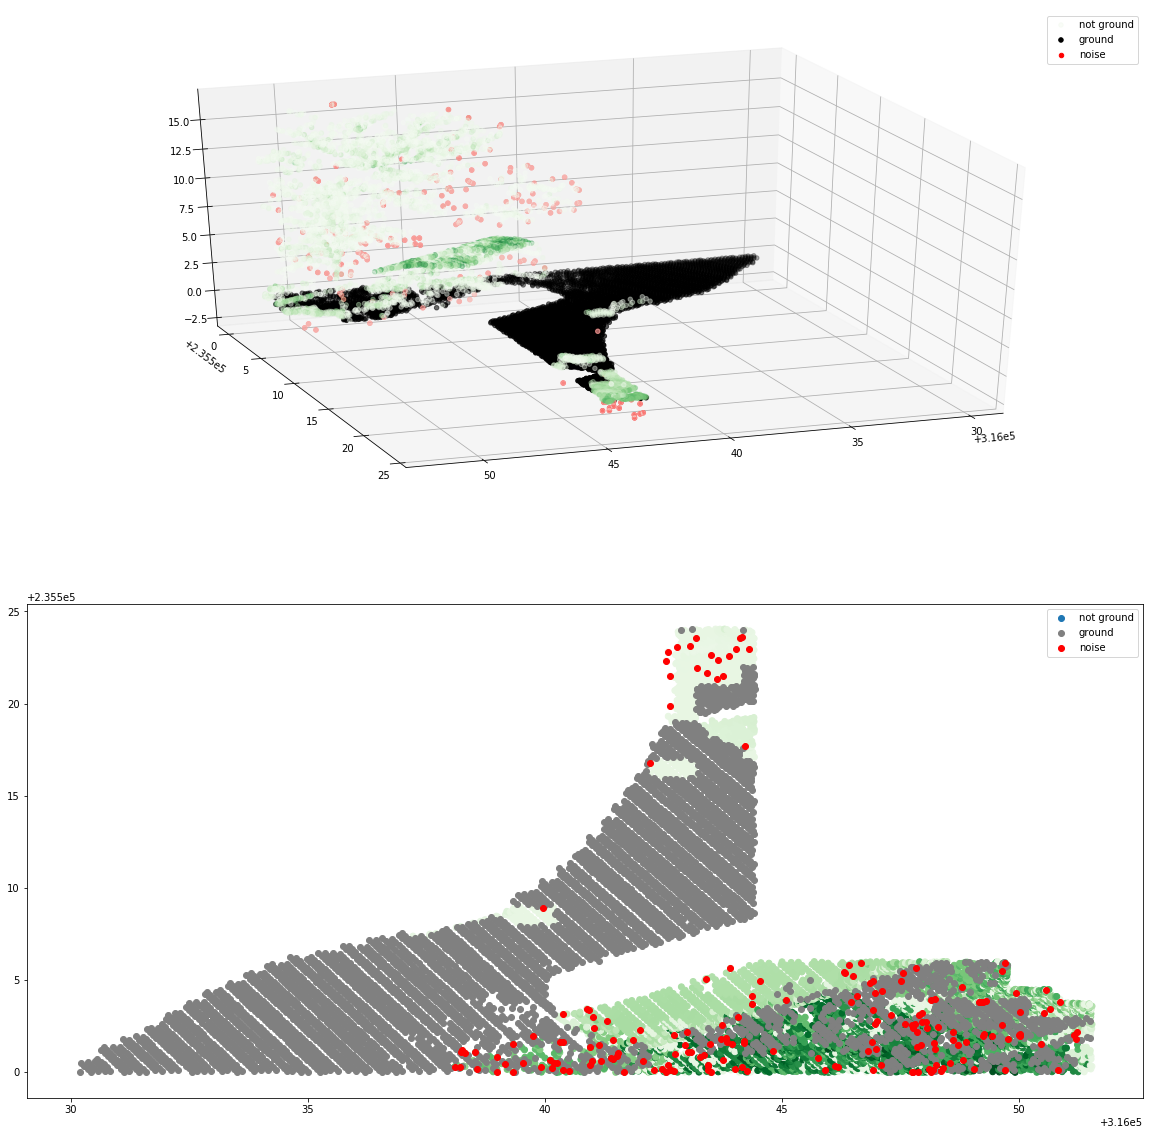

In [311]:
plotthethings(df4, df4.HeightAboveGround, 10000)

### No morton filter

In [272]:
pipelineJson5 = {
  "pipeline": [ workingfile,
    {
        "type":"filters.assign",
        "assignment":"Classification[:]=0"
    },
    {
        "type":"filters.elm",
        "cell":20.0,
        "class":7
    },
    {
        "type":"filters.pmf",
        "ignore":"Classification[7:7]"
    },
    {
        "type":"filters.outlier"
    },
    {
        "type":"filters.hag"
    }
  ]
}

In [273]:
%%time

df5 = pdal2df(pipelineJson5, workingfile)

CPU times: user 55.2 s, sys: 1.05 s, total: 56.3 s
Wall time: 55.9 s


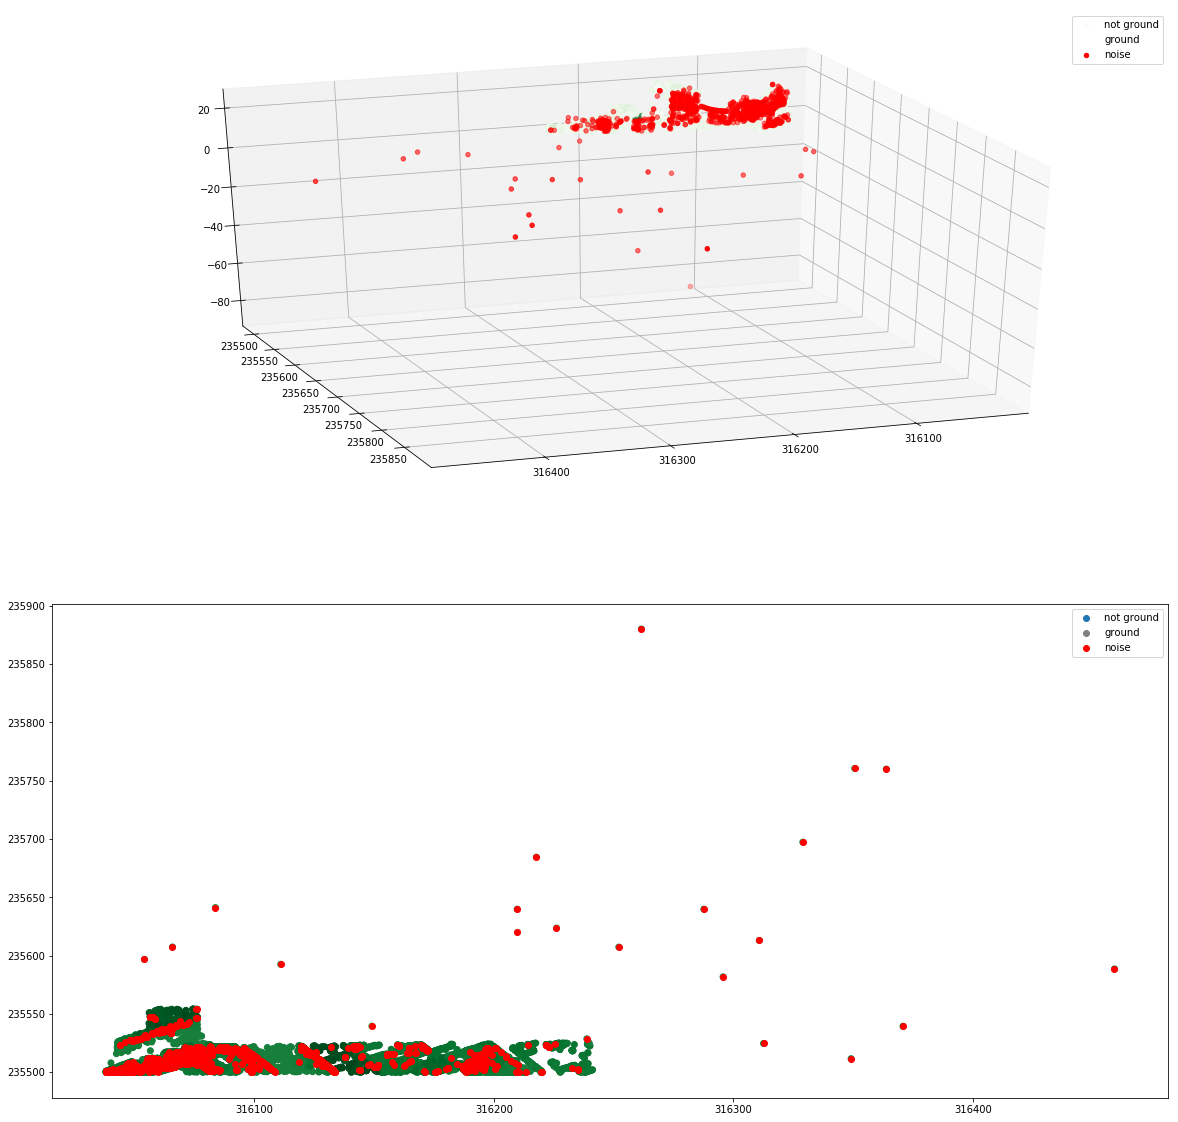

In [314]:
plotthethings(df5, df5.HeightAboveGround, 50000)